# Performance Analization For WiFi FP
This will be a simple document dedicated to analizing the performance of the WIFI FP algorithm at different settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import similarity as sm
import radiomap as rm
import wifi_fp as fp

In [3]:
# read data from data files
training_data    = pd.read_csv("sample_data/TrainingData.csv")
validation_data  = pd.read_csv("sample_data/ValidationData.csv")
wap_column_names = training_data.filter(regex=("WAP\d*")).columns
training_data    = training_data.drop(columns=["RELATIVEPOSITION", "USERID", "SPACEID"])

# initial processing of data -> normalization and scaling
training_data = fp.initial_data_processing(training_data)
validation_data = fp.initial_data_processing(validation_data)

In [4]:
# create the radiomap object from the training set
grid_size = [2,2]
rm_per_area = rm.create_radiomap_objects(training_data, grid_size)

In [5]:
# check validation dataset results
wknn_qtile = 0.95
nwap_fields = [v for v in validation_data.columns.to_list() if v not in wap_column_names]
validation_results = pd.DataFrame(np.nan, columns=nwap_fields + ['FPx', 'FPy', 'error'], index=validation_data.index)

for index, row in validation_data.iterrows():
    cur_x, cur_y, cur_error = fp.calculate_line_location(row, rm_per_area, qtile=wknn_qtile)
    validation_results.loc[index, nwap_fields+['FPx', 'FPy', 'error']] = row[nwap_fields].to_list() + [cur_x, cur_y, cur_error]
all_verrors = validation_results.error[~np.isnan(validation_results.error)].values

## Check validation results per device

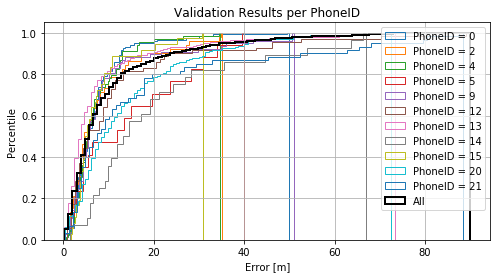

    grp  err_prc90  err_median  total_num  nonan_num
0     0  12.894273    5.703077        120        119
1     2  18.956216    4.806114         52         52
2     4  12.966448    5.657389         69         69
3     5  32.313669   12.023420         17         17
4     9  20.397589    5.834438         77         77
5    12  24.178329    5.813926         70         70
6    13  19.219058    3.941494        369        369
7    14  47.629367   13.977132         28         28
8    15  14.088149    5.183228         36         36
9    20  31.719493    9.370967        213        213
10   21  53.666880    8.096001         60         60
11  All  23.999684    5.850360       1111       1110


In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
validation_summary = []
validation_results_grp = validation_results.groupby(["PHONEID"])
for grp in validation_results_grp.groups.keys():
    td_grp = validation_results_grp.get_group(grp)
    verrors = td_grp.error[~np.isnan(td_grp.error)].values
    ax.hist(verrors, 100, density=True, histtype='step', cumulative=True, label="PhoneID = " + str(round(grp)))
    validation_summary.append({"grp": str(round(grp)), 
                               "err_prc90": np.quantile(verrors, 0.9), 
                               "err_median": np.median(verrors, axis=None), 
                               "total_num": len(td_grp), 
                               "nonan_num": len(verrors)})
ax.hist(all_verrors, 100, density=True, histtype='step', cumulative=True, label="All", color="black", linewidth=2)
plt.xlabel('Error [m]')
plt.ylabel('Percentile')
plt.title('Validation Results per PhoneID')
plt.grid()
plt.legend()
plt.show()

validation_summary.append({"grp": "All", 
                            "err_prc90": np.quantile(all_verrors, 0.9), 
                            "err_median": np.median(all_verrors, axis=None), 
                            "total_num": len(validation_results), 
                            "nonan_num": len(all_verrors)})
validation_summary = pd.DataFrame(validation_summary)
print(validation_summary)

We may notice that there's some specific devices with higher errors than the others.
For example, devices (5, 14, 20, 21) all have a 0.9 quantile larger than 30m, significantly more than the rest. There are many possible explainations for this issue.

We were also able to locate all validation data except for one case.

It's worth noting that the results here are pretty much at the expected range (besides the outliers): in most papers values of between 14m to 21m are expected for the 95th percentile, and between 5m to 8m for the median. The lower end is typically the result of a kalman filter algorithm. Usually all the data is analyzed with a kernel or some interpolation, so the check here is a bit more limited, but in the expected error range.